<a href="https://colab.research.google.com/github/higor-gomes93/mce_pesquisa_geicon/blob/main/MCE_Estendido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
grafo = nx.DiGraph()

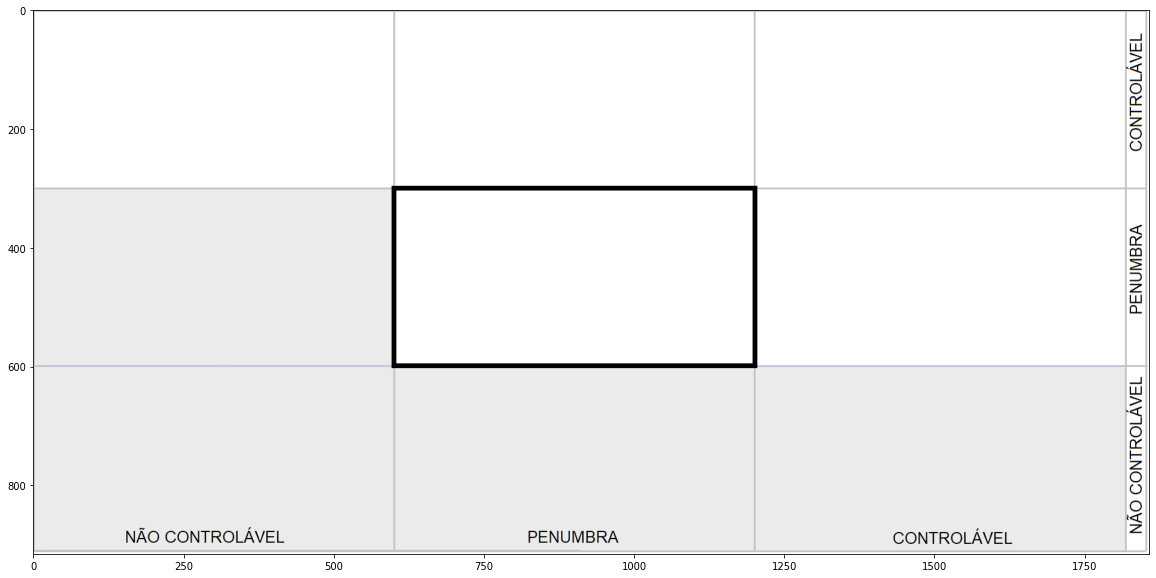

In [3]:
fundo = plt.imread('MCE.png')
plt.figure(figsize=(20, 10))
plt.imshow(fundo, aspect='auto')

In [4]:
vertices = [
    'Perspectiva de alcançar um futuro melhor', 
    'Falta de empatia',
    'Equilíbrio entre trabalho e descanso',
    'Ideologias e objetivos próprios',
    'Poder',
    'o desejo de vencer',
    'Stress nas relações sociais',
    'Produtividade dos colaboradores',
    'Perspectiva de alcançar um futuro melhor',
    'Falta de empatia',
]

areastas = [
     ('Perspectiva de alcançar um futuro melhor', 'o desejo de vencer'),
     ('Falta de empatia', 'Stress nas relações sociais'),
     ('Equilíbrio entre trabalho e descanso', 'Produtividade dos colaboradores'),
     ('Ideologias e objetivos próprios', 'Perspectiva de alcançar um futuro melhor'),
     ('Poder', 'Falta de empatia')           
]

In [5]:
posicao = {
    'Perspectiva de alcançar um futuro melhor': (1387, 105), 
    'Falta de empatia': (1585, 213),
    'Equilíbrio entre trabalho e descanso': (1289, 221),
    'Ideologias e objetivos próprios': (1472, 190),
    'Poder': (1362, 346),
    'o desejo de vencer': (1625, 141),
    'Stress nas relações sociais': (1320, 54),
    'Produtividade dos colaboradores': (1288, 275),
    'Perspectiva de alcançar um futuro melhor': (1554, 87),
    'Falta de empatia': (1509, 227),
}

In [6]:
grafo.add_nodes_from(vertices)
grafo.add_edges_from(areastas)

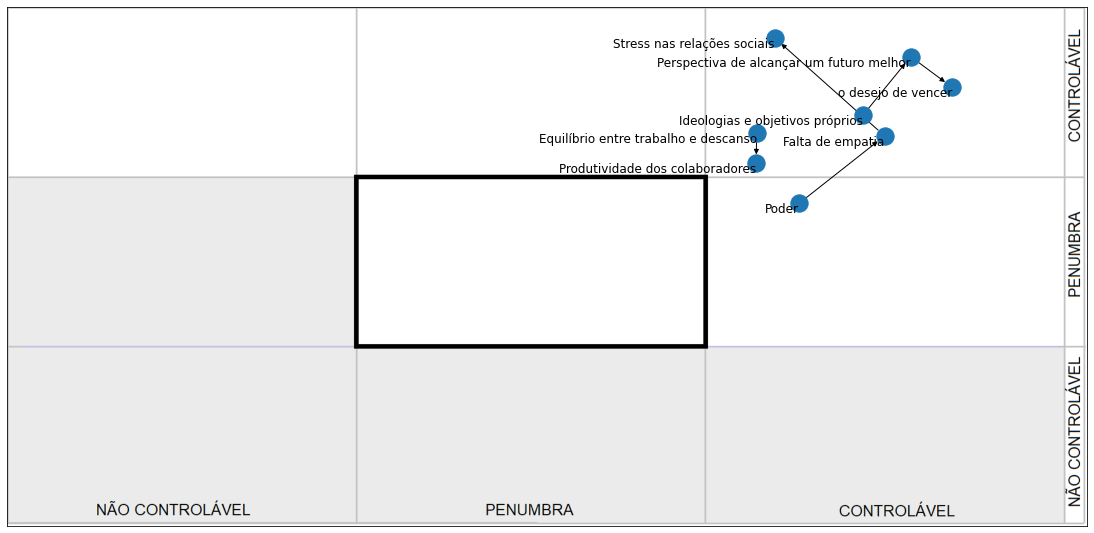

In [31]:
fig = plt.figure(figsize=(19.354, 9.542))
plot = nx.draw_networkx_nodes(grafo, posicao, node_shape='o')
plot = nx.draw_networkx_edges(grafo, posicao, edgelist = areastas)
plot = nx.draw_networkx_labels(grafo, posicao, horizontalalignment='right', verticalalignment='top')
plt.imshow(fundo, aspect='auto')
teste = plt.savefig('/content/drive/My Drive/figura6')
plt.show(plot)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


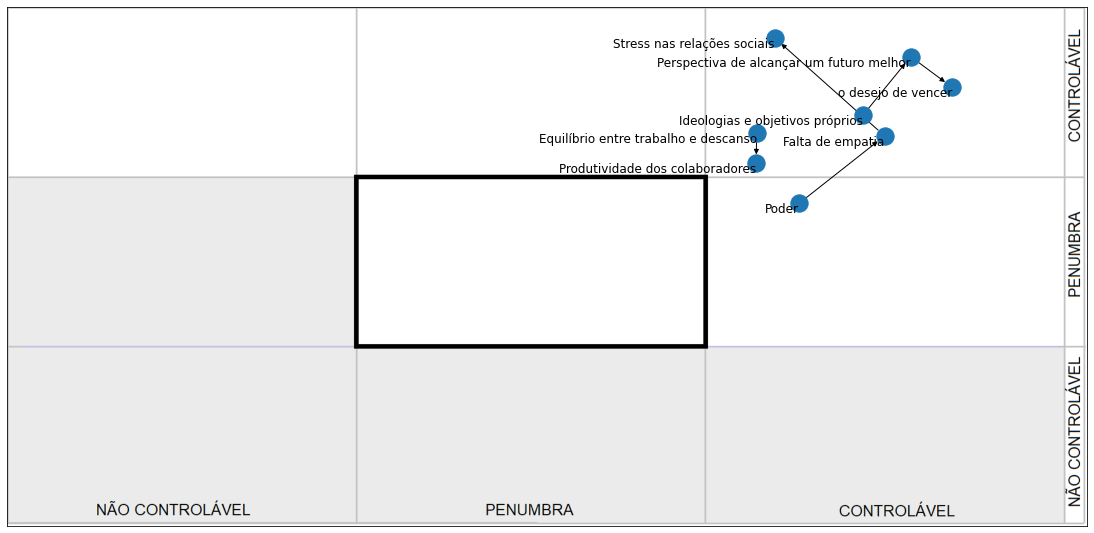

In [37]:
fig = plt.figure(figsize=(19.354, 9.542))
plot = nx.draw_networkx_nodes(grafo, posicao, node_shape='o')
plot = nx.draw_networkx_edges(grafo, posicao, edgelist = areastas)
plot = nx.draw_networkx_labels(grafo, posicao, horizontalalignment='right', verticalalignment='top')
plt.imshow(fundo, aspect='auto')
teste = plt.savefig('/content/drive/My Drive/Mestrado/MCE/Figura7')
plt.show(plot)